# SMPy Demonstrations & Validation

This notebook demonstrates the core functionalities of the **SMPy** package and verifies its behavior against known "truth" data. These demonstrations are aligned with the requirements for [JOSS (Journal of Open Source Software)](https://joss.theoj.org/) submission criteria.

**Key Features Demonstrated:**
1. **Feature Demonstrations**
    - Kaiser-Squires reconstruction in both RA/Dec and pixel coordinate systems
    - E/B mode decomposition
    - Signal-to-Noise Ratio (SNR) map generation using spatial and orientation shuffling
    - Peak detection with thresholding and result output

**Data Used:**
- The example input file path are provided at the top of this notebook. This data is from mock SuperBIT galaxy cluster observations (Lensing in the Blue II, McCleary et al, 2023). Adjust them to point to your local data if needed.

**Important Note:**
This notebook assumes that:
- SMPy is installed and accessible (either via `pip install .` from the SMPy directory or placed in your Python path).
- The input FITS files exist and are accessible at the specified file paths.

Let's begin with the demonstrations.


# 0. Just use the run file (skip pedagogy)
If you want to skip the pedagogy and run SMPy in a jupyter notebook or python file, you only need the following three lines in the code:

In [4]:
from smpy import run
# Define your own config path
config_path = '/home/wslgeorgios/SMPy/smpy/configs/example_config.yaml'
run.run(config_path)

Convergence map saved as PNG file: /home/wslgeorgios/SMPy/examples/outputs/simulation_testing_kaiser_squires_e_mode.png
Convergence map saved as PNG file: /home/wslgeorgios/SMPy/examples/outputs/simulation_testing_snr_e_mode.png


### **The following demonstrates a walk through of the various steps in the SMPy algorithm, for demonstration purposes.**

In [5]:
import os
import yaml
%matplotlib inline

# Import internal SMPy functions used by the runner
from smpy.run import read_config
from smpy.coordinates import get_coordinate_system
from smpy.utils import load_shear_data
from smpy.mapping_methods.kaiser_squires.kaiser_squires import ks_inversion
from smpy.plotting import filters, plot
from smpy.error_quantification.snr.run import create_sn_map


## 1. Load Configuration

We will load the `example_config.yaml` from the SMPy repository.


In [6]:
config_path = "/home/wslgeorgios/SMPy/smpy/configs/example_config.yaml"
with open(config_path, 'r') as file:
    yaml.safe_load(file)

# Temporarily change certain parameters in config for notebook purposes
config = read_config(config_path)
config['general']['output_directory'] = '/home/wslgeorgios/SMPy/examples/notebooks/figures/'
config['general']['output_base_name'] = 'simulation_SIMS'

general_config = config['general']

coord_system_type = config.get('coordinate_system', 'radec').lower()
coord_system = get_coordinate_system(coord_system_type)
coord_config = config['general'].get(coord_system_type, {})


The configuration is now loaded into a dictionary.


## 2. Load Shear Data

Next, we load the input shear data using `utils.load_shear_data`. The required column names are defined in the config (`g1_col`, `g2_col`, `weight_col`, and the coordinate columns under the chosen coordinate system section).


In [15]:
shear_df = load_shear_data(
    shear_cat_path= general_config['input_path'],
    coord1_col=     coord_config['coord1'],
    coord2_col=     coord_config['coord2'],
    g1_col=         general_config['g1_col'],
    g2_col=         general_config['g2_col'],
    weight_col=     general_config['weight_col'],
    hdu=            general_config['input_hdu']
)

print("Shear data loaded. DataFrame shape:", shear_df.shape)
shear_df.head()


Shear data loaded. DataFrame shape: (8767, 5)


,coord1,coord2,g1,g2,weight
0,199.436121,32.975130,-0.832185,-0.329239,3.289114
1,199.649709,32.975024,-0.045790,-0.618257,3.676469
2,199.382810,32.975117,0.708573,0.527764,3.639724
3,199.383113,32.974996,0.523717,0.502735,3.586006
4,199.547529,32.975129,-0.085572,-0.037222,3.682295


## 3. Calculate Boundaries

For the chosen coordinate system, we must calculate field boundaries. This helps define the grid on which we place the shear data.


In [8]:
scaled_boundaries, true_boundaries = coord_system.calculate_boundaries(
    shear_df['coord1'].values,
    shear_df['coord2'].values
)
scaled_boundaries, true_boundaries

({'coord1_min': -0.18722942097666068,
  'coord1_max': 0.187374154186019,
  'coord2_min': -0.1249562347123998,
  'coord2_max': 0.1249562347123998,
  'coord1_name': 'Scaled RA',
  'coord2_name': 'Scaled Dec',
  'units': 'deg'},
 {'coord1_min': 199.27629273813943,
  'coord1_max': 199.72359671796983,
  'coord2_min': 32.974996404477174,
  'coord2_max': 33.224908873901974,
  'coord1_name': 'RA',
  'coord2_name': 'Dec',
  'units': 'deg'})

`scaled_boundaries` are adjusted boundaries, accounting for RA projection effects, while `true_boundaries` represent the original coordinate ranges. (assuming `radec` mode)

## 4. Transform Coordinates

If needed, we transform the coordinates (for example, in RA/Dec mode we center and scale them). This step prepares the data for gridding.


In [9]:
shear_df = coord_system.transform_coordinates(shear_df)
shear_df.head()


,coord1,coord2,g1,g2,weight,coord1_scaled,coord2_scaled
0,199.436121,32.975130,-0.832185,-0.329239,3.289114,-0.053542,-0.124823
1,199.649709,32.975024,-0.045790,-0.618257,3.676469,0.125639,-0.124928
2,199.382810,32.975117,0.708573,0.527764,3.639724,-0.098266,-0.124836
3,199.383113,32.974996,0.523717,0.502735,3.586006,-0.098011,-0.124956
4,199.547529,32.975129,-0.085572,-0.037222,3.682295,0.039919,-0.124824


Now `shear_df` should have `coord1_scaled` and `coord2_scaled` columns ready for binning.

## 5. Create Shear Grid

We bin the galaxy shear measurements onto a regular 2D grid. The coordinate system class handles this, producing `g1map` and `g2map`.


In [10]:
g1_map, g2_map = coord_system.create_grid(
    shear_df, 
    scaled_boundaries,
    general_config
)

print("Shear grids created.")
print("g1_map shape:", g1_map.shape)
print("g2_map shape:", g2_map.shape)


Shear grids created.
g1_map shape: (38, 57)
g2_map shape: (38, 57)


## 6. Perform Kaiser-Squires Inversion

We now convert these shear maps to convergence maps using the Kaiser-Squires method. This yields E-mode and B-mode convergence maps.


In [11]:
# Determine g2 sign convention
if coord_system_type == 'radec':
    g2_sign = -1
else:
    g2_sign = 1

kappa_e, kappa_b = ks_inversion(g1_map, g2_sign * g2_map)

filter_config = config['convergence'].get('smoothing')
kappa_e_filtered = filters.apply_filter(kappa_e, filter_config)
kappa_b_filtered = filters.apply_filter(kappa_b, filter_config)



## 7. Plot the Convergence Maps Inline

Let's visualize the E-mode and B-mode maps here in the notebook. Normally, SMPy saves these as PNG files, but we can also display them directly.


In [12]:
from IPython.display import Image, display

Convergence map saved as PNG file: /home/wslgeorgios/SMPy/examples/notebooks/figures/simulation_SIMS_kaiser_squires_E_mode.png
Convergence map saved as PNG file: /home/wslgeorgios/SMPy/examples/notebooks/figures/simulation_SIMS_kaiser_squires_B_mode.png
Convergence maps plotted and saved.
Displaying E-mode Convergence Map:


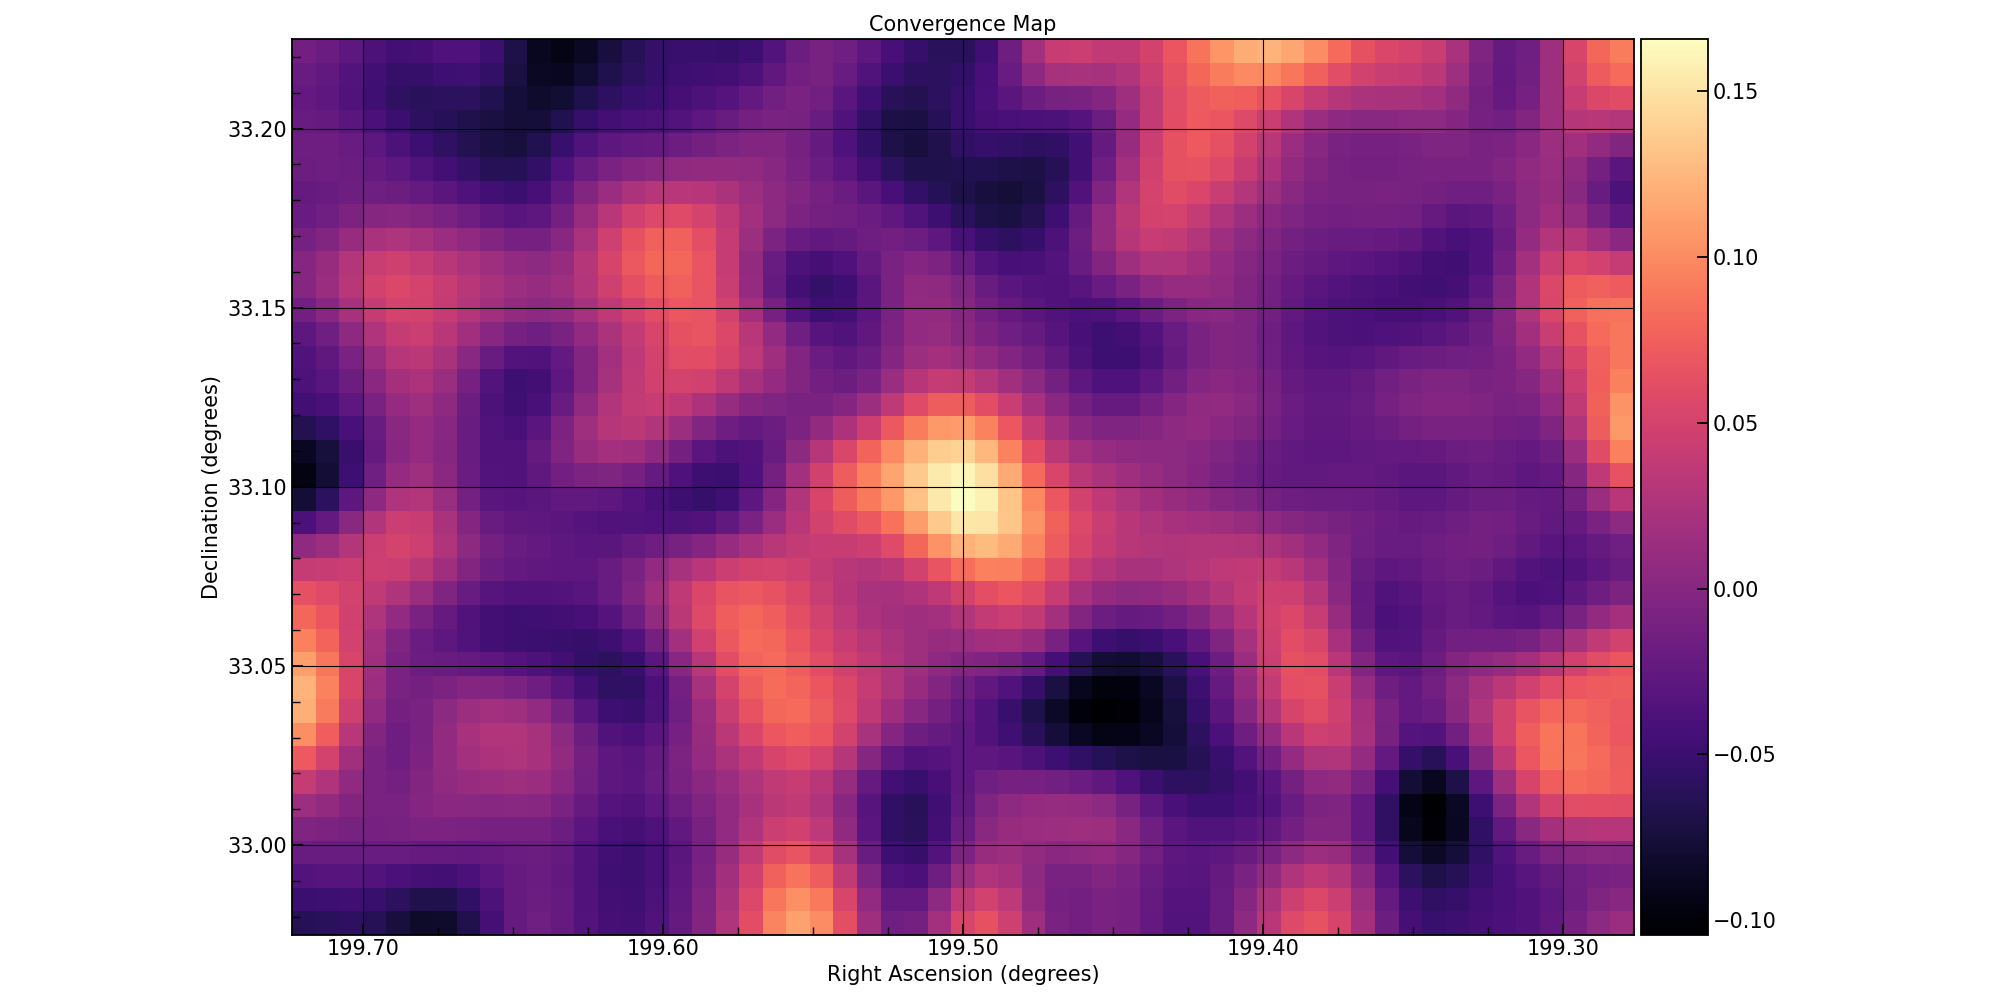

Displaying B-mode Convergence Map:


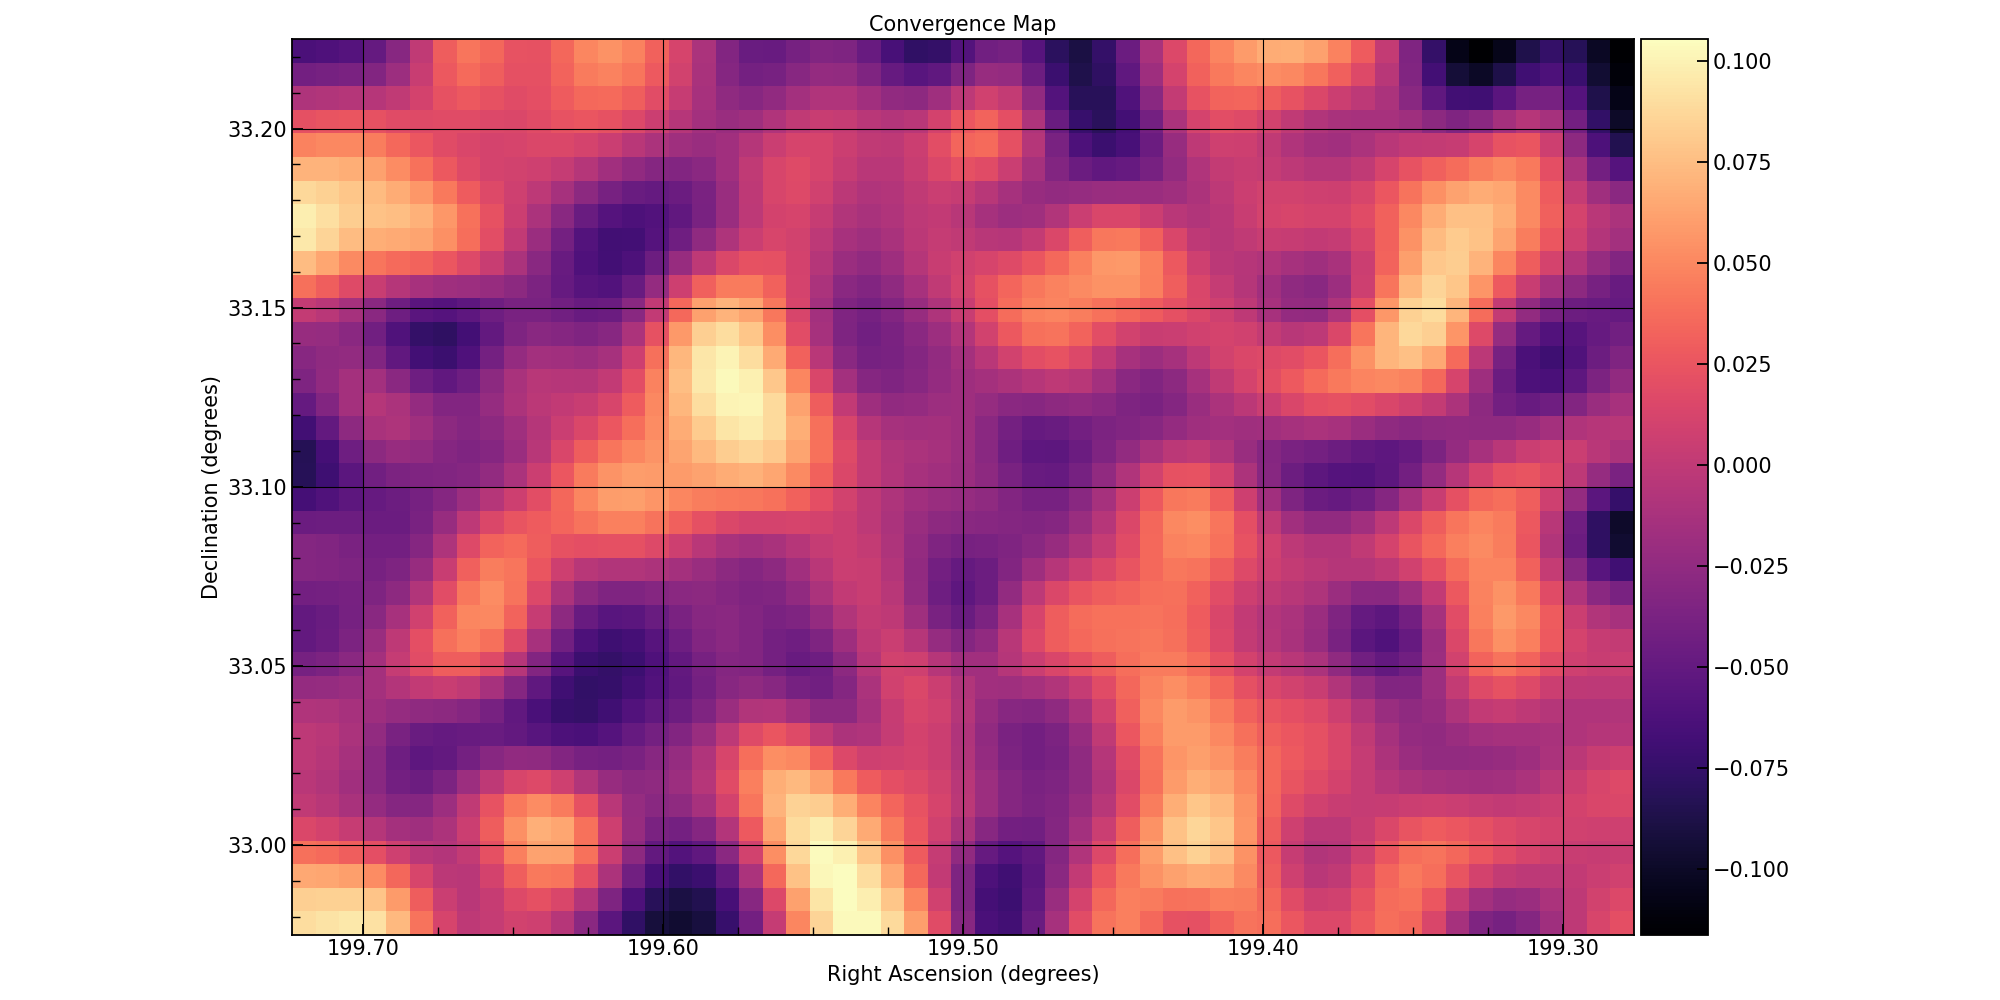

In [13]:
# Define output file names based on config
output_dir = general_config['output_directory']
output_base = general_config['output_base_name']

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Plot E-mode convergence map
e_output_name = os.path.join(output_dir, f"{output_base}_kaiser_squires_E_mode.png")
plot.plot_convergence(
    filtered_convergence=kappa_e_filtered,
    scaled_boundaries=scaled_boundaries,
    true_boundaries=true_boundaries,
    config=config['convergence'],
    output_name=e_output_name
)

# Plot B-mode convergence map
b_output_name = os.path.join(output_dir, f"{output_base}_kaiser_squires_B_mode.png")
plot.plot_convergence(
    filtered_convergence=kappa_b_filtered,
    scaled_boundaries=scaled_boundaries,
    true_boundaries=true_boundaries,
    config=config['convergence'],
    output_name=b_output_name
)

print("Convergence maps plotted and saved.")

# Display the saved images inline
print("Displaying E-mode Convergence Map:")
display(Image(filename=e_output_name))

print("Displaying B-mode Convergence Map:")
display(Image(filename=b_output_name))


## 8. Generate SNR Maps

If the configuration specifies to create SNR maps (`create_snr: true`), we will generate them using SMPy's `create_sn_map` function. This involves shuffling the shear catalog to create noise realizations and then computing the signal-to-noise ratio for the reconstructed convergence maps.



Detected Peaks:
------------------------------------------------------------
Peak #  Value       RA          Dec         
------------------------------------------------------------
1       5.01798.....199.49994...33.10324....
2       2.78514.....199.30376...33.03090....
------------------------------------------------------------
Convergence map saved as PNG file: /home/wslgeorgios/SMPy/examples/notebooks/figures/simulation_SIMS_snr_e_mode.png
SNR maps generated and saved.
Displaying SNR map for E-mode:


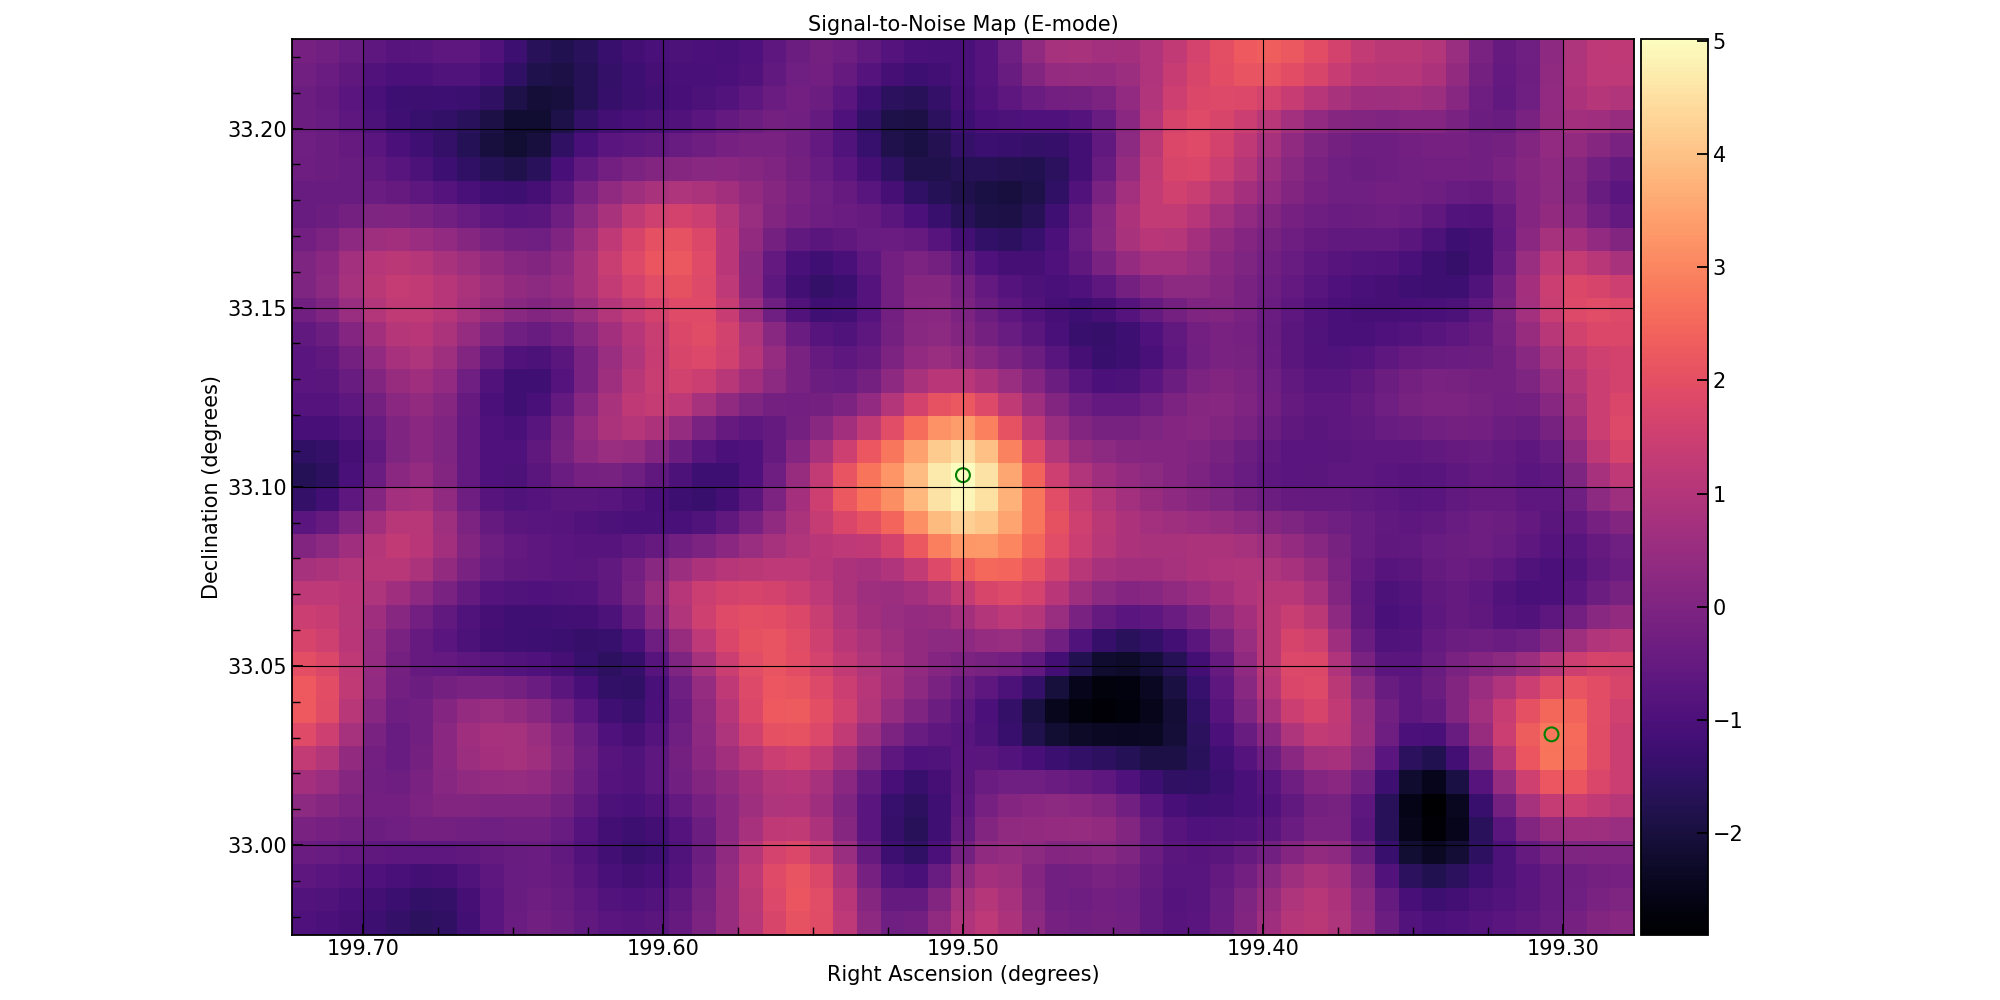

In [14]:
if general_config.get('create_snr', False):
    # Package convergence_maps as expected by create_sn_map
    convergence_maps = {'E': kappa_e, 'B': kappa_b}
    snr_config = {**general_config, **config['snr']}
    snr_config['threshold'] = 2.7
    snr_config['verbose'] = True
    # Generate SNR maps
    create_sn_map(
        config=snr_config,
        convergence_maps=convergence_maps,
        scaled_boundaries=scaled_boundaries,
        true_boundaries=true_boundaries
    )
    
    print("SNR maps generated and saved.")
    
    # Display the saved SNR maps
    snr_base = f"{output_base}_snr"
    modes = config['general']['mode']
    
    for mode in modes:
        snr_output_name = os.path.join(output_dir, f"{snr_base}_{mode.lower()}_mode.png")
        if os.path.exists(snr_output_name):
            print(f"Displaying SNR map for {mode}-mode:")
            display(Image(filename=snr_output_name))
        else:
            print(f"SNR map for {mode}-mode not found at {snr_output_name}")
else:
    print("SNR maps not requested in example_config.yaml (create_snr is False).")


**Note:** The `create_sn_map` function handles:
- **Shuffling:** Depending on `shuffle_type`, it either spatially shuffles galaxy positions or randomizes their orientations.
- **Noise Realizations:** Generates multiple noise maps to estimate the variance.
- **SNR Calculation:** Divides the observed convergence by the noise RMS to produce SNR maps.
- **Plotting:** Saves the SNR maps as PNG files and optionally displays peaks based on thresholds.

Ensure that your configuration (`example_config.yaml`) has `create_snr: true` and appropriate SNR settings to generate these maps.
